# Initial Setup

We can see here that the model with the following criteria:
- 1 Convolution Hidden Layer
   - 8 Convolution Filter
   - Relu Activation
   - 1 Max Pooling layer with stride = 2
   - `he_normal` initializer
- 1 Hidden layer
   - 100 nodes in layer
   - Relu Activation
   - `he_normal` initializer
- Categorical Cross Entropy loss function
- One hot encoded labels as target
- Adam optimizer

## Imports

In [16]:
import mnist_data_load
import pandas as pd
import numpy as np
import logging
import random
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
import tensorflow as tf

## Logging

In [2]:
get_logging = True

In [3]:
if get_logging:
    logging.getLogger().setLevel(logging.INFO)

In [4]:
random_seed = 100
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Check GPU status

In [5]:
assert len(tf.config.experimental.list_physical_devices('GPU')) == 1

# Load the data

In [6]:
train_data, validation_data, test_data = mnist_data_load.load_data(seed=random_seed)

INFO:root:handling label: 1
INFO:root:handling label: 0
INFO:root:handling label: 4
INFO:root:handling label: 7
INFO:root:handling label: 3
INFO:root:handling label: 5
INFO:root:handling label: 8
INFO:root:handling label: 9
INFO:root:handling label: 2
INFO:root:handling label: 6


In [7]:
x_train, y_train = mnist_data_load.get_label_and_features_from_dataframe(train_data)

In [8]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)

In [9]:
logging.info(x_train.shape)
logging.info(y_train.shape)
logging.info(np.unique(y_train))
logging.info(y_train_one_hot.shape)

INFO:root:(30360, 28, 28, 1)
INFO:root:(30360,)
INFO:root:[0 1 2 3 4 5 6 7 8 9]
INFO:root:(30360, 10)


# Model

In [10]:
def get_basic_model() -> Sequential:
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu',
                     kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [11]:
basic_model = get_basic_model()

In [12]:
basic_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [13]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               135300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 136,390
Trainable params: 136,390
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
# setting basic hyperparameters
#learning_rate = 0.01
batch_size = 32
epochs = 5

In [15]:
history_train = basic_model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
949/949 [==============================] - 3s 3ms/step - loss: 3.2111 - accuracy: 0.8678 - precision: 0.8725 - recall: 0.8644
Epoch 2/5
949/949 [==============================] - 3s 3ms/step - loss: 0.3432 - accuracy: 0.9284 - precision: 0.9432 - recall: 0.9179
Epoch 3/5
949/949 [==============================] - 3s 3ms/step - loss: 0.1955 - accuracy: 0.9529 - precision: 0.9635 - recall: 0.9459
Epoch 4/5
949/949 [==============================] - 3s 3ms/step - loss: 0.1547 - accuracy: 0.9605 - precision: 0.9672 - recall: 0.9554
Epoch 5/5
949/949 [==============================] - 3s 3ms/step - loss: 0.1183 - accuracy: 0.9689 - precision: 0.9742 - recall: 0.9655


In [18]:
logging.info(type(history_train))

INFO:root:<class 'tensorflow.python.keras.callbacks.History'>


In [20]:
with open('cnn_1x8_onehot_training.json', 'w') as f:
    f.write(json.dumps(history_train.history))

## Validation

In [21]:
x_val, y_val = mnist_data_load.get_label_and_features_from_dataframe(validation_data)

In [22]:
y_val_one_hot = tf.keras.utils.to_categorical(y_val, 10)

In [23]:
logging.info(x_val.shape)
logging.info(y_val.shape)
logging.info(y_val_one_hot.shape)

INFO:root:(3790, 28, 28, 1)
INFO:root:(3790,)
INFO:root:(3790, 10)


In [24]:
history_validation = basic_model.evaluate(x_val, y_val_one_hot, batch_size=batch_size, verbose=1)

119/119 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.9599 - precision: 0.9641 - recall: 0.9567


## Testing

In [25]:
x_test, y_test = mnist_data_load.get_label_and_features_from_dataframe(test_data)

In [26]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [27]:
logging.info(x_test.shape)
logging.info(y_test.shape)
logging.info(y_test_one_hot.shape)

INFO:root:(7850, 28, 28, 1)
INFO:root:(7850,)
INFO:root:(7850, 10)


In [28]:
prediction = basic_model.predict(x_test, verbose=1)

246/246 [==============================] - 0s 1ms/step


In [29]:
len(prediction)

7850

In [30]:
result = (prediction.argmax(axis=1) == y_test).sum()

In [31]:
accuracy_test = result/len(y_test)

In [32]:
logging.info(accuracy_test)

INFO:root:0.9612738853503184


# Accuracy graphs

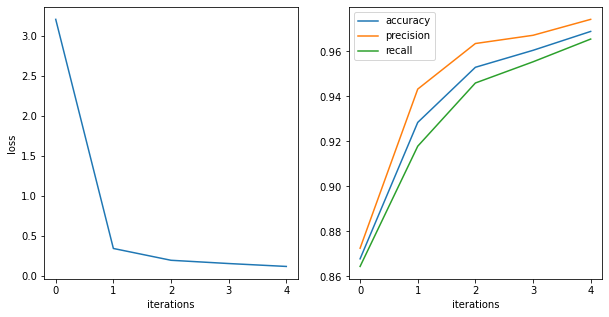

In [33]:
plt.figure(figsize=(10, 5))
subplt1 = plt.subplot(1, 2, 1)
subplt1.plot(range(5), history_train.history['loss'], label='loss')
subplt2 = plt.subplot(1, 2, 2)
subplt2.plot(range(5), history_train.history['accuracy'], label='accuracy')
subplt2.plot(range(5), history_train.history['precision'], label='precision')
subplt2.plot(range(5), history_train.history['recall'], label='recall')
subplt1.set_xlabel('iterations')
subplt1.set_ylabel('loss')
subplt2.set_xlabel('iterations')
subplt2.legend(loc='best')
plt.show()

In [34]:
basic_model.save('cnn_1x8_onehot.h5')

# Visualizing weights and hidden layer

In [35]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               135300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 136,390
Trainable params: 136,390
Non-trainable params: 0
_________________________________________________________________


## 1st convolution layer

In [36]:
conv1 = basic_model.get_layer('conv2d')

In [37]:
conv1.get_config()

{'name': 'conv2d',
 'trainable': True,
 'batch_input_shape': (None, 28, 28, 1),
 'dtype': 'float32',
 'filters': 8,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 2.0,
   'mode': 'fan_in',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

### Visualizing weights

In [38]:
conv1_w = conv1.get_weights()

In [39]:
conv1_w = np.array(conv1_w, dtype=object)

In [40]:
for w in conv1_w:
    logging.info(w.shape)

INFO:root:(3, 3, 1, 8)
INFO:root:(8,)


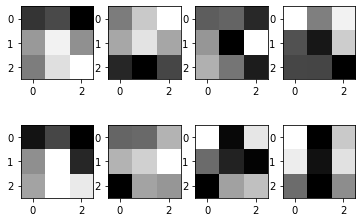

In [41]:
for i in range(8):
    subplt = plt.subplot(2, 4, i+1)
    subplt.imshow(conv1_w[0][:, :, 0, i], cmap='gray')
plt.show()

### Visualizing the ouput

We need to create another model with the same 1st layer as our base model and output being the layer 1st layer itself. This will give us the (1, 26, 26, 8) shaped output which will contain the output of all the 8 filters stacked together. We can plot this output to understand what our model learned in the 1st convolution layer.

In [42]:
# creatin a intermediate model
conv_1_08_model = Sequential()
conv_1_08_model.add(conv1)

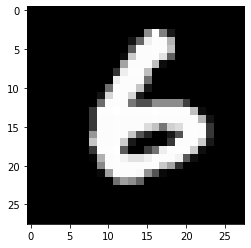

In [44]:
# getting a random image for prediction
# the image features of this prediction is what we are trying to visualize
i = random.randint(0, x_test.shape[0])
conv1_test_feat = x_test[i]
plt.imshow(conv1_test_feat, cmap='gray')
plt.show()

In [45]:
logging.info(conv1_test_feat.reshape((1,28,28,1)).shape)

INFO:root:(1, 28, 28, 1)


In [46]:
conv1_out = conv_1_08_model.predict(conv1_test_feat.reshape((1,28,28,1)))

In [47]:
logging.info(conv1_out.shape)

INFO:root:(1, 26, 26, 8)


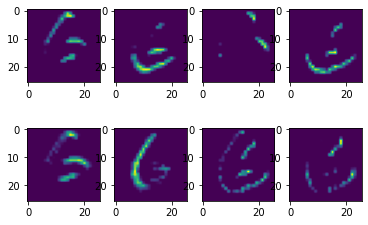

In [48]:
for i in range(8):
    subplt = plt.subplot(2, 4, i+1)
    subplt.imshow(conv1_out[0, :, :, i])
plt.show()

In [49]:
def conv1_test_output(num_examples):
    random_index = [random.randint(0, x_test.shape[0]) for i in range(num_examples)]
    random_feat = x_test[random_index]
    assert len(random_feat.shape) == 4
    intermediate_model = Sequential()
    intermediate_model.add(conv1)
    pred = intermediate_model.predict(random_feat)
    for index, p in enumerate(pred):
        fig = plt.figure(figsize=(16, 3), constrained_layout=True)
        grid = gridspec.GridSpec(1, 3, figure=fig)
        grid0 = grid[0]
        grid1 = grid[1].subgridspec(2, 4)
        grid2 = grid[2].subgridspec(2, 4)
        fig.add_subplot(grid0).imshow(random_feat[index], cmap='gray')
        for i in range(8):
            row = i // 4
            col = i % 4
            subplt = fig.add_subplot(grid1[row, col])
            subplt.imshow(conv1_w[0][:, :, 0, i], cmap='gray')
        for i in range(8):
            row = i // 4
            col = i % 4
            subplt = fig.add_subplot(grid2[row, col])
            subplt.imshow(p[:,:,i], cmap='gray')
        plt.show()

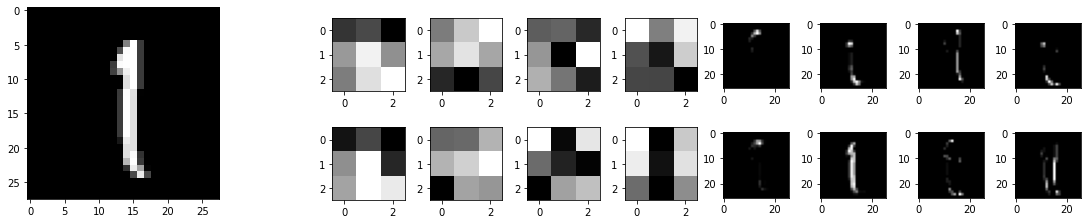

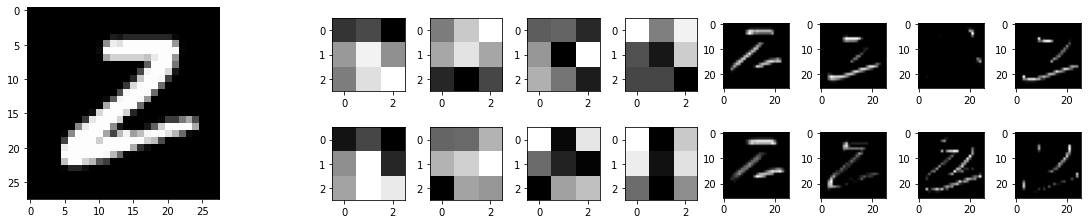

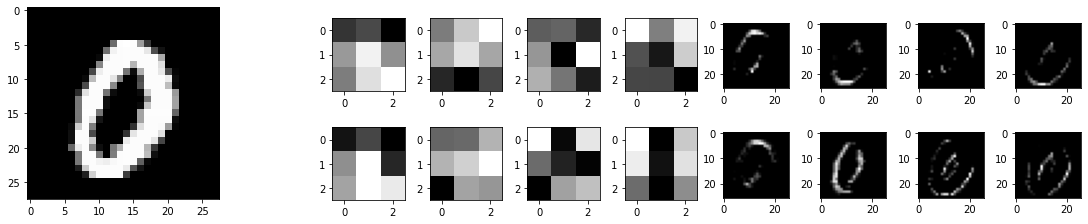

In [50]:
conv1_test_output(3)